<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# Greenhouse climate simulation

In this notebook, a simplified greenhouse simulation model is built to model the effect of temperature, humidity, and CO2 on the photosynthesis of a (cucumber) plant. The optimization will be carried out using reinforcement learning in the next notebook.

We use data from [S. Hemming et al, Remote Control of Greenhouse Vegetable Production with Artificial Intelligence—Greenhouse Climate, Irrigation, and Crop Production, 2019](https://www.researchgate.net/publication/332480787_Remote_Control_of_Greenhouse_Vegetable_Production_with_Artificial_Intelligence-Greenhouse_Climate_Irrigation_and_Crop_Production) to simulate weather conditions and approximate greenhouse parameters.

This notebook starts with exploring the measured data from the article mentioned above. Next, models for weather, plant (synthesis), and the greenhouse are built.

## Greenhouse and weather data exploration

The dataset used in the above-mentioned paper can be downloaded from [this site](https://data.4tu.nl/articles/dataset/Autonomous_Greenhouse_Challenge_First_Edition_2018_/12717758/1). Download and unzip the dataset.

The Pandas library is used to read the data files for the weather, greenhouse climate, and control. Check the ReadMe.pdf file that came with the dataset for information on the data files.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read weather data
df1 = pd.read_csv('https://github.com/illyakaynov/masterclass-drl-wur/raw/master/greenhouse/data/meteo.csv')

In [3]:
# plot first few row table
df1.head(5)

,time,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp
0,8/14/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8/14/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8/14/2018,13.369189,0.0,0.0,-32.000000,0.0,0.0,87.8,17.7,32.0,3.2
3,8/14/2018,13.389380,0.0,0.0,-36.000000,0.0,0.0,87.4,17.8,32.0,3.2
4,8/14/2018,13.455197,0.0,1.0,-38.999999,0.0,0.0,87.3,17.9,32.0,3.2


The data has been samples with 5 minutes intervals. Below we plot 7 days of data.

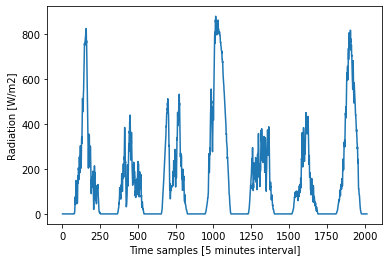

In [4]:
# plot 7 days of data
N = 7 * 24 * 60 // 5
df1['Iglob'][0:N].plot()
plt.xlabel("Time samples [5 minutes interval]")
plt.ylabel("Radiation [W/m2]");

In [5]:
# read greenhouse climate data
df2 = pd.read_csv('https://raw.githubusercontent.com/illyakaynov/masterclass-drl-wur/master/greenhouse/data/Greenhouse_climate.csv')

In [6]:
# plot first few row
df2.head(5)

,AssimLight,BlackScr,CO2air,EnScr,GHtime,HumDef,PipeGrow,PipeLow,RHair,Tair,VentLee,Ventwind
0,NaN,NaN,NaN,NaN,43326.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,43326.003472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,484.0,0.0,43326.006944,2.76,0.0,0.0,84.2,20.2,0.0,0.0
3,0.0,0.0,479.0,0.0,43326.010417,2.64,0.0,0.0,84.6,19.9,0.0,0.0
4,0.0,0.0,482.0,0.0,43326.013889,2.60,0.0,0.0,84.8,19.9,0.0,0.0


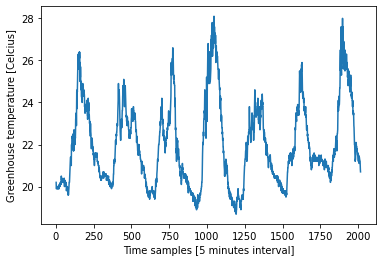

In [7]:
# plot some data
df2['Tair'][0:N].plot();
plt.xlabel("Time samples [5 minutes interval]")
plt.ylabel("Greenhouse temperature [Celcius]");

In [8]:
# read greenhouse control data
df3 = pd.read_csv('https://github.com/illyakaynov/masterclass-drl-wur/raw/master/greenhouse/data/vip.csv')

In [9]:
# plot first few row
df3.head(5)

,CO2_Vip,HeatTemp_Vip,HumDef_Vip,MinPipeGrow_Vip,MinPipeLow_Vip,VentLeewMin_Vip,VentLeew_Vip,VentWind_Vip,WaterSupInt_Vip,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43326.003472
2,NaN,10.0,1.8,0.0,0.0,0.0,20.5,21.0,NaN,43326.006944
3,NaN,10.0,1.8,0.0,0.0,0.0,20.5,21.0,NaN,43326.010417
4,NaN,10.0,1.8,0.0,0.0,0.0,20.5,21.0,NaN,43326.013889


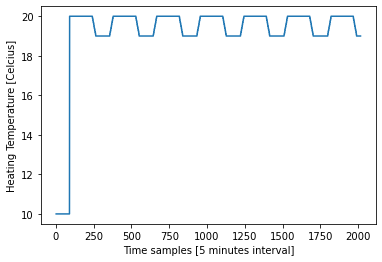

In [10]:
# plot some data
df3['HeatTemp_Vip'][0:N].plot();
plt.xlabel("Time samples [5 minutes interval]")
plt.ylabel("Heating Temperature [Celcius]");

In [11]:
# check sizes dataframes and notice they differ in size
# we assume that they all start at same start start time
df1.size, df2.size, df3.size

(364463, 397596, 331330)

In [12]:
# create one big dataframe for easy plotting
df_total = pd.concat([df1, df2, df3], axis=1)

In [13]:
# plot support function
def plot_data(data, labels, Nstart, Nduration):
    n_vars = len(labels)
    
    fig, axs = plt.subplots(n_vars, 1, figsize=(12, 2*n_vars), sharex=True)
    
    t = np.linspace(0, 5 * Nduration / 60, Nduration)
    
    for i in range(n_vars):
        ax = axs[i]
        ax.plot(t, data[labels[i]][Nstart:Nstart+Nduration])
        ax.set_xlabel('Time [hours]')
        ax.set_ylabel(labels[i])
        
    plt.tight_layout()

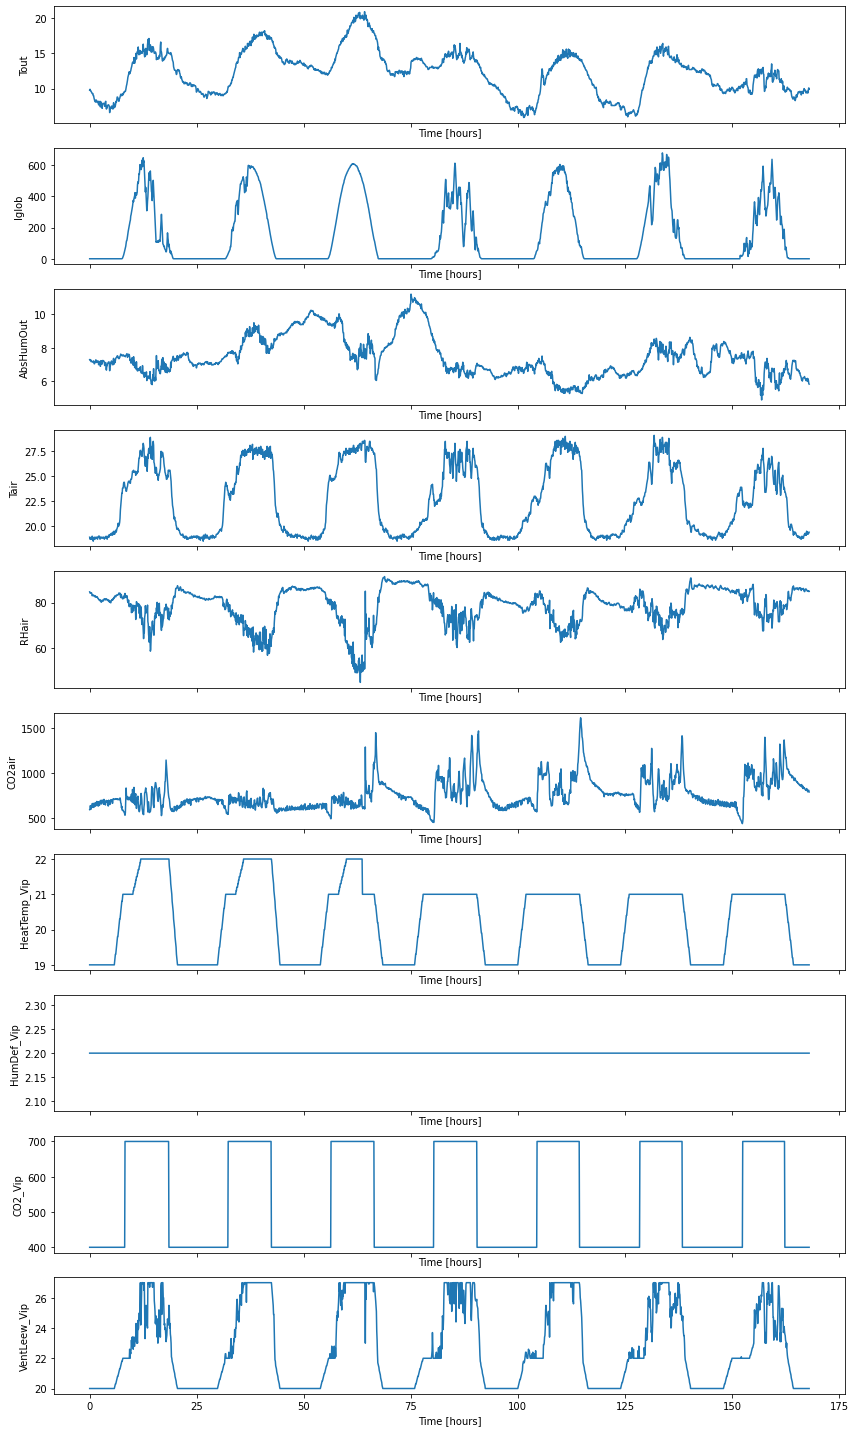

In [14]:
# plot several variables to get an overview of the data
plot_data(df_total, 
          ['Tout', 'Iglob', 'AbsHumOut', 'Tair', 'RHair', 'CO2air', 'HeatTemp_Vip', 'HumDef_Vip', 'CO2_Vip', 'VentLeew_Vip'], 
          Nstart = 42 * 24 * 60 // 5, Nduration = 7 * 24 * 60 // 5)

## Weather model

A simple weather model is needed for simulating the greenhouse climate. In our weather model we take into account the following variables:

- Temperature: outside temperate, measured in Celcius degrees.
- Relative humidity: measured in %.
- Solar power: measured in W/m2.
- CO2 concentration: measured in ppm.

For our weather model, additional functions are defined for converting units, such as 

- absolute to relative humidity, 
- CO2 ppm to gram per m3, and vice versa.

In [15]:
# define function to calculate saturated vapor density
def saturated_vapor_density(temperature):
    # Calculate saturated vapor density mg/m3
    # For data see http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/watvap.html
    # Saturated vapor density table has been fitted to 3rd polynome using Excel
    # Temperate: degrees
    # vapor density: gr/m3
    return 0.0006*temperature**3 - 0.0021*temperature**2+0.3322*temperature + 5.8649

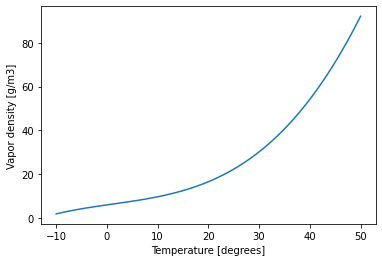

In [16]:
temp = np.linspace(-10, 50, 100)
plt.plot(temp, saturated_vapor_density(temp))
plt.xlabel('Temperature [degrees]')
plt.ylabel('Vapor density [g/m3]');

In [17]:
# define functions to convert data from one unit to another
def ppm_to_gpm3(CO2_ppm):
    # convert CO2 ppm to gram/m3
    return CO2_ppm * 44.01 / (24.45 * 1000)

def gpm3_to_ppm(CO2_gpm3):
    # convert CO2 gram/m3 to ppm
    return 24.45 * CO2_gpm3 * 1000 / 44.01

def rh_to_gpm3(humidity, temperature):
    # convert relative humidity to gram/m3
    return saturated_vapor_density(temperature) * humidity / 100.0

def gpm3_to_rh(vapor_density, temperature):
    return 100 * vapor_density / saturated_vapor_density(temperature)

To build the simulation model and to prepare it for reinforcement learning use, the following classes are needed:

- Model: defines the dynamics between variables
- Observation: hold information measured from a model without modifying the model
- Action: holds information to influence the variables of a model

We recommend adding the units of the variables in the comments, to avoid making errors in the units.

In [30]:
class WeatherObservation:
    def __init__(self, 
                 temperature = 17,       # degrees 
                 relative_humidity = 40, # % 
                 solar_power = 0,        # W/m2
                 CO2 = 350               # ppm
                ):
        self.temperature = temperature 
        self.relative_humidity = relative_humidity
        self.solar_power = solar_power
        self.CO2 = CO2
        
    def to_numpy(self):
        return np.array([self.temperature, self.relative_humidity, self.solar_power, self.CO2])
    
    @staticmethod
    def size():
        return 4
    
    @staticmethod
    def labels():
        return ['Temperature [C]', 'Rel. Humidity [%]', 'Solar power [W/m2]', 'CO2 [ppm]']
    
    
class WeatherDefault:
    """Default weather model to test purpose."""
    def __init__(self, 
                 temperature = 17,       # degrees 
                 relative_humidity = 40, # % 
                 solar_power = 0,        # W/m2
                 CO2 = 350):             # ppm)
        self.obs = WeatherObservation(temperature, relative_humidity, solar_power, CO2)
                 
    # default Weather model
    def reset(self):
        return self.obs
    
    def step(self):
        return self.obs
    
    
class Weather:
    """Weather model that uses weather data from csv file."""
    def __init__(self):
        # read data from cvs file
        # columns:
        # 'time', 'AbsHumOut', 'Iglob', 'PARout', 'Pyrgeo', 'RadSum', 'Rain',
        # 'Rhout', 'Tout', 'Winddir', 'Windsp'
        self.data = pd.read_csv('https://github.com/illyakaynov/masterclass-drl-wur/raw/master/greenhouse/data/meteo.csv').values[:,1:].astype(np.float64)
        # correct nan values first two rows
        self.data[0,:] = self.data[2,:]
        self.data[1,:] = self.data[2,:]        
        
    def reset(self):
        self.counter = 0
        obs = WeatherObservation(
                 temperature = self.data[self.counter, 7],       # degrees 
                 relative_humidity = self.data[self.counter, 6], # % 
                 solar_power = self.data[self.counter, 1],       # W/m2
                 CO2 = 350
              )
        return obs
    
    def step(self):
        self.counter += 1
        obs = WeatherObservation(
                 temperature = self.data[self.counter, 7],       # degrees 
                 relative_humidity = self.data[self.counter, 6], # % 
                 solar_power = self.data[self.counter, 1],       # W/m2
                 CO2 = 350
              )
        return obs

# Plant model

A simplified plant model is used. For now, we're only interested in the total amount of CO2 absorbed by a plant.

We assume photosynthesis (CO2 absorption) depends on (solar) radiation power [W/m2], temperature, and CO2 concentration. A model is followed from [this](https://studyrocket.co.uk/revision/gcse-biology-edexcel/triple-plant-structures-their-functions/photosynthesis) website (see picture below). For each graph, a formula is derived below.

<img src="./images/photosynthesis.png">

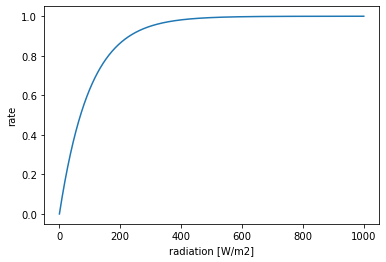

In [31]:
# light intensity
radiation = np.linspace(0, 1000, 1000) # W/m2
plt.plot(radiation, 1- np.exp(-radiation/100))
plt.xlabel('radiation [W/m2]')
plt.ylabel('rate');

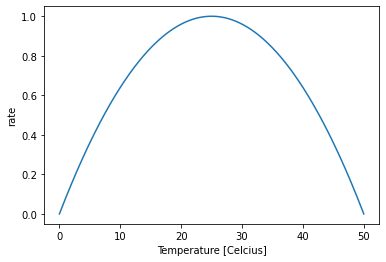

In [32]:
# light intensity
temperature = np.linspace(0, 50, 1000) # W/m2
plt.plot(temperature, 1.0 - 0.0016*(temperature-25.0)**2)
plt.xlabel('Temperature [Celcius]')
plt.ylabel('rate');

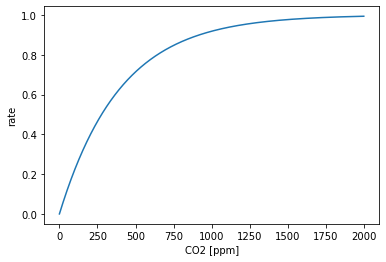

In [33]:
# CO2
CO2 = np.linspace(0, 2000, 1000) # W/m2
plt.plot(CO2, 1- np.exp(-CO2/400))
plt.xlabel('CO2 [ppm]')
plt.ylabel('rate');

Also for the plant model, we need to devise an `Action`, `Observation`, and `Model` class. Besides the three models above we also added to the plant model the fact that a plant needs to 'rest'. This was simplified by hard coding the period 5u00 - 23u00 where the plant generates $CO_2$, and 23u00 - 5u00 when the plant is 'at rest' and produces $CO_2$.

In [34]:
class PlantAction:
    def __init__(self, radiation=0, CO2=0, temperature=0):
        self.radiation = radiation      # W/m2
        self.CO2 = CO2                  # g/m3 green house CO2
        self.temperature = temperature  # Celcius green house temperature
        
    def to_numpy(self):
        return np.array([self.radiation])
    
    @staticmethod
    def size():
        return 4
    
    @staticmethod
    def labels():
        return ['Radiation [W/m2]', 'CO2 [g/m3]', 'Temperature [Celcius]']

        
        
class PlantObservation:
    def __init__(self, CO2_absorption_rate=0, CO2_total=0):
        self.CO2_absorption_rate = CO2_absorption_rate   # g/m2/s
        self.CO2_total = CO2_total                       # g/m2

    def to_numpy(self):
        return np.array([self.CO2_absorption_rate, self.CO2_total])
    
    @staticmethod
    def size():
        return 2
    
    @staticmethod
    def labels():
        return ['CO2 absorption rate [g/m2/h]', 'CO2 total [gram]']

        
class Plant:
    def __init__(self):
        self.sample_time = 5  # minutes
        
        # photosynthesis
        self.plant_CO2_generation = 0.1                # g/m2/h
        self.optimal_CO2_absorption = ppm_to_gpm3(800) # g/m3

    def reset(self):
        self.total_CO2 = 0   # gram/m2
        self.time = 0        # minutes
        return PlantObservation(0, 0)
        
    def step(self, action):
        hour = (self.time / 60) % 24
        
        # simple equation to model fact that plant needs rest
        if (hour > 5.0) and (hour < 23.0):
            CO2_absorption_rate = -self.photosynthesis_rate(action) * self.optimal_CO2_absorption / 3600
        else:
            CO2_absorption_rate = self.plant_CO2_generation / 3600
            
        # update total CO2
        self.total_CO2 += (-CO2_absorption_rate * self.sample_time * 60)
        
        # update time
        self.time += self.sample_time
                
        return PlantObservation(CO2_absorption_rate, self.total_CO2) 
        
    def photosynthesis_rate(self, action: PlantAction):        
        return (1.0 - np.exp(-action.radiation/(500.0))) * \
               (1.0 - np.exp(-gpm3_to_ppm(action.CO2)/400)) * \
               (1.0 - 0.0016*(np.clip(action.temperature, 0.0, 50.0)-25.0)**2)

# Greenhouse

Finally, a greenhouse model is developed that simulates the following variables:

- temperature,
- CO2 concentration,
- humidity.

This model consists of several physical processes that are discussed below.

## Greenhouse temperature

The greenhouse temperature depends on how much heat is added (via the heater, environment, etc) and how much heat is lost. The heat capacity of the greenhouse is estimated by hand and checked to be in line with the data from the mentioned paper in section 1.

$$
C \cdot \frac{dT}{dt} = P
$$

with 

- $C$: the heat capacity $[\frac{J}{Km^2}]$
- $dT$: temperature difference $[K]$ or [Celcius]
- $dt$: time difference $[s]$
- $P$: total power $[\frac{W}{m^2}] = [\frac{J}{sm^2}]$.

The total power is the sum of heat supplied (heater, solar radiation) and heat loss (open window, fogging).


### Heat loss
Part of the heat is lost via the walls and roof of the greenhouse. When the window is open the loss increases.

$$
P_{loss} = U \cdot \Delta T
$$

with

- $P$: heat loss power $[\frac{W}{m^2}] = [\frac{J}{sm^2}]$
- $U$: heat loss coefficient $[\frac{W}{Km^2}]$
- $\Delta T$: Temperature difference $[K]$.

This equation can be used to model heat loss when the window is closed and open. The only difference is the value of the heat loss coefficient $U$.



### Solar heating
Sun radiation also heats the greenhouse. We use a reflectance parameter to scale the amount of radiation power $[W/m^2]$.

$$
P_{solar\_heat} = (1-r) \cdot P_{solar\_power}
$$

with

- $P_{solar\_heat}$: heating power due to sun $[\frac{W}{m^2}] = [\frac{J}{sm^2}]$
- $P_{solar\_power}$: solar power $[\frac{W}{m^2}] = [\frac{J}{sm^2}]$
- $r$: reflectance of glass roof and walls $[%]$.


### Fogging

When fogging is turned on, the temperature will decrease and the relative humidity will increase. the water vapor density in the air can never be higher than the saturated water vapor density at the current temperature.

$$
\frac{dm_{vapor}}{dt} = c \cdot (m_{sat} - m_{vapor}) \cdot V_{fogging}
$$

with

- $c$: evaporation coefficient $[\frac{m^3}{gram}]$
- $m_{vapor}$: water vapor density in air $[\frac{gram}{m^3}]$
- $m_{sat}$: saturated water vapor density in air $[\frac{gram}{m^3}]$
- $V_{fogging}$: added water vapor by fogging system $[\frac{gram}{s}]$

The heat needed for evaporation equals

$$
P_{evaporation} = c \cdot \frac{dm_{vapor}}{dt}
$$

with

- $P_{evaporation}$: heat needed for evaporation $[W]$ = $[\frac{J}{s}]$
- $c$: evaporation heat $[\frac{J}{gram}]$


### CO2
$CO_2$ is simulated by keeping track of the netto $CO_2$. $CO_2$ can be supplied and is lost via the window.

$$
\frac{dQ}{dt} = f
$$

with 

- $Q$: CO2 concentration $[g/m2]$
- $f$: CO2 net flow $[g/m2/s]$
- $dt$: time difference $[s]$

In [35]:
class GreenhouseAction:
    def __init__(self, heater=0, window=0, vapor_supply=0, CO2_supply=0, light=0):        
        self.heater = heater                # heater on/off (1/0)
        self.window = window                # window open/closed (1/0)
        self.vapor_supply = vapor_supply    # vapor system on/off (1/0)
        self.CO2_supply = CO2_supply        # CO2 supply on/off (1/0)
        self.light = light
        
    def to_numpy(self):
        return np.array([self.heater, self.window, self.vapor_supply, self.CO2_supply, self.light])
    
    @staticmethod
    def size():
        return 5
    
    @staticmethod
    def labels():
        return ['Heater on/off', 'Window open/closes', 'Vapor on/off', 'CO2 on/off', 'Light on/off']

    
class GreenhouseObservation:
    def __init__(self, time, temperature, humidity, CO2, weather, plant):     
        self.time = time                # minutes  0 = 00:00 1 jan 2020
        self.temperature = temperature  # degrees
        self.humidity = humidity        # % relative humidity
        self.CO2 = CO2                  # ppm
        self.weather = weather          # weather observation
        self.plant = plant

    def to_numpy(self):
        return np.concatenate([np.array([self.time, self.temperature, self.humidity, self.CO2]),
                               self.weather.to_numpy(),
                               self.plant.to_numpy()])

    @staticmethod
    def size():
        return 4 + WeatherObservation().size() + PlantObservation.size()
    
    @staticmethod
    def labels():
        return ['Time [min]', 'GH Temperature [C]', 'GH Rel. Humidity [%]', 'GH CO2 [ppm]'] + \
               WeatherObservation().labels() + \
               PlantObservation.labels()

    
class Greenhouse:
    def __init__(self, weather_model=WeatherDefault(), plant_model=Plant()):
        # greenhouse dimensions
        self.area = 96                    # m2
        self.height = 5                   # m
        
        # green house specifications
        # heat capacity J/K/m2
        self.heat_capacity = 100000

        # heat loss coefficient W/K
        self.heat_loss_window_closed = 10
        self.heat_loss_window_open   = 20      
        
        # solar reflectance of glass
        self.reflectance = 0.5           # %
        
        # solar radiation to PAR (photosynthesis active radiation)
        self.solar_power_to_par = 4.6
                
        # actuator specifications
        self.max_heating_capacity = 120     # W/m2
        self.max_vapor_capacity = 30        # g/m2/h
        self.max_CO2_capacity = 15          # g/m2/h
        self.max_ventilation_capacity = 5.0 # m3/h
        self.max_light_capacity = 187       # umol/m2/s
                
        # vapor heat dissipation
        self.evaporation_coeff = 0.05             # m3/g
        self.evaporation_heat_dissipation = 10000 # W/g
            
        # simulation parameters
        self.sample_time = 5                # minutes
        
        # weather model
        self.weather_model = weather_model      
        
        # plant model
        self.plant_model = plant_model
        
        # reward
        self.cost_heat = -0.01       # €/kW/m2
        self.cost_CO2 = -2000.0      # €/kg/m2
        self.cost_vapor = -1/1.08e5  # €/kg/m2                
        self.cost_light = -10/7.2e5  # €/umol/m2
        self.plant_CO2 = 2000        # €/g        
                
    def reset(self):
        self.time = 0             # minutes
        self.temp = 20            # degrees
        self.vapor_density = np.clip(5.0, 0, saturated_vapor_density(self.temp)) # g/m3
        self.CO2 = 0.6            # g/m3
        
        # total resource consumption
        self.total_heat = 0     # kW/m2
        self.total_CO2 = 0      # kg/m2
        self.total_vapor = 0    # kg/m2    
        self.total_light = 0    # umol/m2
                
        # reset weather model
        self.weather_obs = self.weather_model.reset()
        
        # reset plant model
        self.plant_obs = self.plant_model.reset()
                
        return GreenhouseObservation(self.time,
                                     self.temp,
                                     humidity = gpm3_to_rh(self.vapor_density, self.temp),
                                     CO2 = gpm3_to_ppm(self.CO2),
                                     weather = self.weather_obs,
                                     plant = self.plant_obs)
    
    def step(self, action: GreenhouseAction) -> GreenhouseObservation:        
        reward = 0
        
        # simulate humidity
        vapor_sat = saturated_vapor_density(self.temp)
        if action.vapor_supply > 0:
            vapor_supply = self.evaporation_coeff * (vapor_sat - self.vapor_density) * \
                           self.max_vapor_capacity / (self.height * 3600)
            self.total_vapor += self.max_vapor_capacity * self.sample_time * 60 / (3600 * 1000)
            reward += self.cost_vapor * self.max_vapor_capacity * self.sample_time * 60 / (3600 * 1000)
        else:
            vapor_supply = 0
        # ventilation
        alpha = np.clip(action.window * self.max_ventilation_capacity / self.height, 0, 1)
        vapor_ventilation = alpha * (rh_to_gpm3(self.weather_obs.relative_humidity, self.weather_obs.temperature) - \
                                     self.vapor_density) / 3600
        vapor_density_next = self.vapor_density + (vapor_supply + vapor_ventilation) * self.sample_time * 60
        
        # simulate temperature
        heat_supply_heater = action.heater * self.max_heating_capacity
        self.total_heat += (heat_supply_heater * self.sample_time * 60 / 1000)
        reward += self.cost_heat * (heat_supply_heater * self.sample_time * 60 / 1000)
        heat_supply_solar = (1-self.reflectance) * self.weather_obs.solar_power
        if action.window > 0:
            heat_loss_window = self.heat_loss_window_open * (self.temp - self.weather_obs.temperature)
        else:
            heat_loss_window = self.heat_loss_window_closed * (self.temp - self.weather_obs.temperature)
        heat_loss_vapor = self.evaporation_heat_dissipation * vapor_supply * self.height
        temp_next = self.temp + (heat_supply_heater + heat_supply_solar - \
                                 heat_loss_vapor - heat_loss_window ) \
                                 * self.sample_time * 60 / self.heat_capacity


        
        
        ### simulate CO2 concentration
        # supply
        CO2_supply = action.CO2_supply * self.max_CO2_capacity / (self.height * 3600) 
        self.total_CO2 += CO2_supply * self.sample_time * 60 / 1000
        reward += self.cost_CO2 * CO2_supply * self.sample_time * 60 / 1000
        # ventilation
        alpha = np.clip(action.window * self.max_ventilation_capacity / self.height, 0, 1)
        CO2_ventilation = alpha * (ppm_to_gpm3(self.weather_obs.CO2) - self.CO2) / 3600
        # total
        CO2_next = self.CO2 + (CO2_supply + self.plant_obs.CO2_absorption_rate + CO2_ventilation) * self.sample_time * 60
        if CO2_next < 0:
            CO2_next = 0
        
        # update light model
        light_supply= action.light * self.max_light_capacity * self.sample_time * 60
        self.total_light += light_supply
        reward += self.cost_light * light_supply
        
        # make observation
        obs = GreenhouseObservation(self.time,
                                    self.temp,
                                    humidity = gpm3_to_rh(self.vapor_density, self.temp),
                                    CO2 = gpm3_to_ppm(self.CO2),
                                    weather = self.weather_obs,
                                    plant = self.plant_obs)    
        
        #
        # prepare next simulation step
        #
        # update weather
        self.weather_obs = self.weather_model.step()
        
        # update plant
        plant_action = PlantAction(radiation=self.solar_power_to_par * self.weather_obs.solar_power + \
                                             action.light * self.max_light_capacity, 
                                   CO2=self.CO2, 
                                   temperature=self.temp)
        self.plant_obs = self.plant_model.step(plant_action)
        reward += self.plant_CO2 * (-1*self.plant_obs.CO2_absorption_rate)

        # update greenhouse variables
        self.temp = temp_next
        self.CO2 = CO2_next
        self.vapor_density = np.clip(vapor_density_next, 0, saturated_vapor_density(temp_next))
        
        # update time
        self.time += self.sample_time
        
        # return observation
        return obs, reward

# Simulation

With our model in place, we can do a simulation. A simple heuristic controller is used for this simulation.

In [36]:
sim_max_minutes = 7 * 24 * 60 // 5

history = np.zeros((sim_max_minutes, GreenhouseObservation.size() + GreenhouseAction.size()))
rewards = np.zeros(sim_max_minutes)

#env = Greenhouse(weather_model=WeatherDefault(temperature=20.0))
env = Greenhouse(weather_model=Weather())
state = env.reset()


for i in range(sim_max_minutes):
    hour = (i % (24 * 12)) / 12
    
    if (hour > 8) & (hour < 20) & (state.CO2 < 800):
        CO2_supply = 1
    else:
        CO2_supply = 0
        
    if (state.temperature > 28.0):
        window = 1
    else:
        window = 0
        
    if (state.temperature < 25.0):
        heater = 1
    else:
        heater = 0
        
    if (state.humidity < 80):
        vapor_supply = 1
    else:
        vapor_supply = 0
    
    if 5 < hour < 23:
        light_supply = 1
    else:
        light_supply = 0
    
    # calculate action
    action = GreenhouseAction(heater=heater, 
                              window=window, 
                              vapor_supply=vapor_supply, 
                              CO2_supply=CO2_supply, 
                              light=light_supply)
    
    #action = GreenhouseAction(heater=0, window=0, vapor_supply=0, CO2_supply=0, light=0)
        
    # do simulation step
    next_state, reward = env.step(action)
    
    # save history data
    history[i,:] = np.concatenate([state.to_numpy(), action.to_numpy()])
    rewards[i] = reward
    
    # prepare next simulation state
    state = next_state

In [37]:
def plot_history(history):
    n_observations = GreenhouseObservation.size()
    n_actions = GreenhouseAction().size()
    n_vars = n_observations + n_actions - 1
    
    fig, axs = plt.subplots(n_vars, 1, figsize=(12, 2*n_vars), sharex=True)
    
    for i in range(1, n_observations):
        ax = axs[i - 1]
        ax.plot(history[:,0] / 60, history[:,i])
        ax.set_xlabel('Time [hours]')
        ax.set_ylabel(GreenhouseObservation.labels()[i])
        
    for i in range(0, n_actions):
        ax = axs[n_observations + i - 1]
        ax.plot(history[:,0] / 60, history[:,n_observations + i])
        ax.set_xlabel('Time [hours]')
        ax.set_ylabel(GreenhouseAction.labels()[i])        
        
    plt.tight_layout()

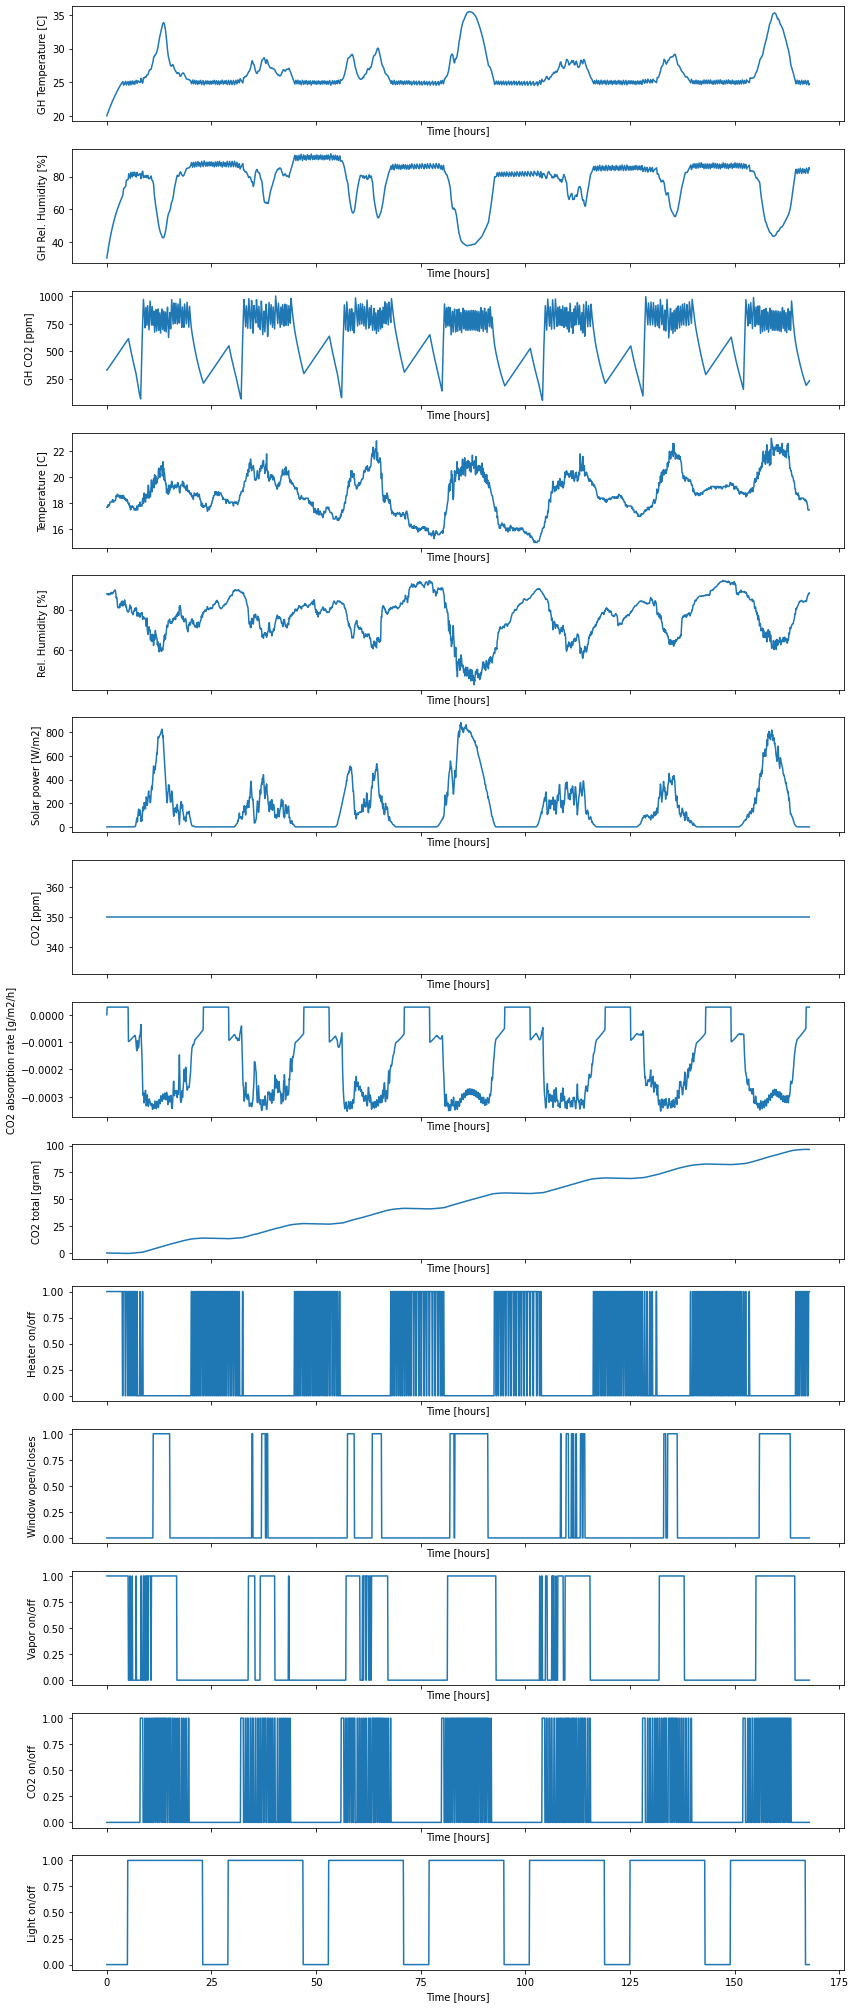

In [38]:
plot_history(history)

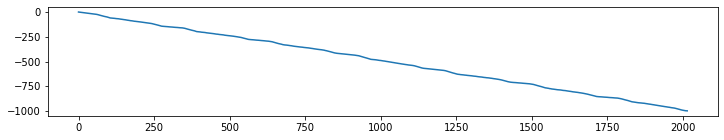

In [39]:
plt.figure(figsize=(12,2))
plt.plot(np.cumsum(rewards))

In [40]:
np.mean(rewards)

-0.49463258375616964

In [41]:
env.total_heat, env.total_CO2, env.total_vapor

(22752.0, 0.12000000000000009, 1.8724999999999712)